# Telecom Company Churn Modeling

## 0.0 Overview

The dataset used in the analysis below was downloaded from [IBM Business Analytics Community](https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113). It represents customer data for a fictional Telecom company. Though the IBM community has previously used this dataset as a tutorial for random forest modeling, the purpose of this notebook is to (i) construct a data exploration from scratch to groom skills and best practices, (ii) test the utility of several modeling approaches, and (iii) potentially draw new and unique conclusions.

### 0.1 Project Setup

In [1]:
# Do not open new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [2]:
import locale
from locale import atof
locale.setlocale(locale.LC_NUMERIC, '')

'en_US.UTF-8'

### 0.2 Helper Functions

In [3]:
def dataframe_eda(df):
    print("\033[1m" + "Dataframe Shape" + "\033[0m")
    print(df.shape)
    print("\n")

    print("\033[1m" + "Column Information" + "\033[0m")
    df.info()
    print("\n")
    
    print("\033[1m" + "Numeric Column Information" + "\033[0m")
    print(df.describe())
    print("\n")

    print("\033[1m" + "Categorical Column Unique Values" + "\033[0m")
    for col in df:
        if len(df[col].unique()) > 10:
            pass
        else:
            print('{}: {}'.format(col, df[col].unique()))

---
## 1.0 Load and Clean Data

In [4]:
churn = pd.read_csv('data/churn.csv')
demographics = pd.read_csv('data/demographics.csv')
location = pd.read_csv('data/location.csv')
population = pd.read_csv('data/population.csv', thousands=',')
services = pd.read_csv('data/services.csv')
status = pd.read_csv('data/status.csv')

### 1.1 Churn Data

In [5]:
dataframe_eda(churn)

Dataframe Shape
(7043, 33)


Column Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 

In [6]:
# Drop Total Charges column - will replace it with clean column from services df

churn.drop(['Total Charges'], axis=1, inplace=True)

### 1.2 Demographic Data

In [7]:
dataframe_eda(demographics)

Dataframe Shape
(7043, 9)


Column Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Customer ID           7043 non-null   object
 1   Count                 7043 non-null   int64 
 2   Gender                7043 non-null   object
 3   Age                   7043 non-null   int64 
 4   Under 30              7043 non-null   object
 5   Senior Citizen        7043 non-null   object
 6   Married               7043 non-null   object
 7   Dependents            7043 non-null   object
 8   Number of Dependents  7043 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 495.3+ KB


Numeric Column Information
        Count          Age  Number of Dependents
count  7043.0  7043.000000           7043.000000
mean      1.0    46.509726              0.468692
std       0.0    16.750352              0.962802
min       1.0    19.

In [8]:
telco = pd.merge(churn.rename(columns={'CustomerID': 'Customer ID'}), 
                 demographics[['Customer ID',
                               'Age',
                               'Under 30',
                               'Number of Dependents'
                              ]],
                 on='Customer ID',
                 how='left')

### 1.3 Location Data

In [9]:
dataframe_eda(location)

Dataframe Shape
(7043, 9)


Column Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Customer ID  7043 non-null   object 
 1   Count        7043 non-null   int64  
 2   Country      7043 non-null   object 
 3   State        7043 non-null   object 
 4   City         7043 non-null   object 
 5   Zip Code     7043 non-null   int64  
 6   Lat Long     7043 non-null   object 
 7   Latitude     7043 non-null   float64
 8   Longitude    7043 non-null   float64
dtypes: float64(2), int64(2), object(5)
memory usage: 495.3+ KB


Numeric Column Information
        Count      Zip Code     Latitude    Longitude
count  7043.0   7043.000000  7043.000000  7043.000000
mean      1.0  93486.070567    36.197455  -119.756684
std       0.0   1856.767505     2.468929     2.154425
min       1.0  90001.000000    32.555828  -124.301372
25%       1.0  92101.0

### 1.4 Population Data

In [10]:
dataframe_eda(population)

Dataframe Shape
(1671, 3)


Column Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671 entries, 0 to 1670
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   ID          1671 non-null   int64
 1   Zip Code    1671 non-null   int64
 2   Population  1671 non-null   int64
dtypes: int64(3)
memory usage: 39.3 KB


Numeric Column Information
                ID      Zip Code     Population
count  1671.000000   1671.000000    1671.000000
mean    836.000000  93678.992220   20276.384201
std     482.520466   1817.763591   20689.117300
min       1.000000  90001.000000      11.000000
25%     418.500000  92269.000000    1789.000000
50%     836.000000  93664.000000   14239.000000
75%    1253.500000  95408.000000   32942.500000
max    1671.000000  96161.000000  105285.000000


Categorical Column Unique Values


In [11]:
telco = pd.merge(telco,
                 population[['Zip Code',
                             'Population'
                            ]],
                 on='Zip Code',
                 how='left')

### 1.5 Services Data

In [12]:
dataframe_eda(services)

Dataframe Shape
(7043, 30)


Column Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 30 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Count                              7043 non-null   int64  
 2   Quarter                            7043 non-null   object 
 3   Referred a Friend                  7043 non-null   object 
 4   Number of Referrals                7043 non-null   int64  
 5   Tenure in Months                   7043 non-null   int64  
 6   Offer                              7043 non-null   object 
 7   Phone Service                      7043 non-null   object 
 8   Avg Monthly Long Distance Charges  7043 non-null   float64
 9   Multiple Lines                     7043 non-null   object 
 10  Internet Service                   7043 non-null   object 
 11  Internet

In [13]:
telco = pd.merge(telco,
                 services[['Customer ID',
                           'Referred a Friend',
                           'Number of Referrals',
                           'Offer',
                           'Avg Monthly Long Distance Charges',
                           'Avg Monthly GB Download',
                           'Streaming Music',
                           'Unlimited Data',
                           'Total Charges',
                           'Total Refunds',
                           'Total Extra Data Charges',
                           'Total Long Distance Charges',
                           'Total Revenue'
                          ]],
                 on='Customer ID',
                 how='left'
                )

### 1.6 Status Data

In [14]:
dataframe_eda(status)

Dataframe Shape
(7043, 11)


Column Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Customer ID         7043 non-null   object
 1   Count               7043 non-null   int64 
 2   Quarter             7043 non-null   object
 3   Satisfaction Score  7043 non-null   int64 
 4   Customer Status     7043 non-null   object
 5   Churn Label         7043 non-null   object
 6   Churn Value         7043 non-null   int64 
 7   Churn Score         7043 non-null   int64 
 8   CLTV                7043 non-null   int64 
 9   Churn Category      1869 non-null   object
 10  Churn Reason        1869 non-null   object
dtypes: int64(5), object(6)
memory usage: 605.4+ KB


Numeric Column Information
        Count  Satisfaction Score  Churn Value  Churn Score         CLTV
count  7043.0         7043.000000  7043.000000  7043.000000  7043.0

In [15]:
telco = pd.merge(telco,
                 status[['Customer ID',
                         'Satisfaction Score'
                        ]],
                 on='Customer ID',
                 how='left'
                )

### 1.7 Merged Data

In [16]:
dataframe_eda(telco)

Dataframe Shape
(7043, 49)


Column Information
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 49 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Count                              7043 non-null   int64  
 2   Country                            7043 non-null   object 
 3   State                              7043 non-null   object 
 4   City                               7043 non-null   object 
 5   Zip Code                           7043 non-null   int64  
 6   Lat Long                           7043 non-null   object 
 7   Latitude                           7043 non-null   float64
 8   Longitude                          7043 non-null   float64
 9   Gender                             7043 non-null   object 
 10  Senior Citizen                     7043 non-null   object 
 11  Partner 

In [17]:
telco.replace({
                'Partner': {'Yes': True, 'No': False},
                'Senior Citizen': {'Yes': True, 'No': False},
                'Dependents': {'Yes': True, 'No': False},
                'Phone Service': {'Yes': True, 'No': False},
                'Multiple Lines': {'Yes': True, 'No': False, 'No phone service': False},
                'Online Security': {'Yes': True, 'No': False, 'No internet service': False},
                'Online Backup': {'Yes': True, 'No': False, 'No internet service': False},
                'Device Protection': {'Yes': True, 'No': False, 'No internet service': False},
                'Tech Support': {'Yes': True, 'No': False, 'No internet service': False},
                'Streaming TV': {'Yes': True, 'No': False, 'No internet service': False},
                'Streaming Movies': {'Yes': True, 'No': False, 'No internet service': False},
                'Streaming Music': {'Yes': True, 'No': False},
                'Paperless Billing': {'Yes': True, 'No': False},
                'Referred a Friend': {'Yes': True, 'No': False},
                'Under 30': {'Yes': True, 'No': False},
                'Unlimited Data': {'Yes': True, 'No': False},
                'Churn Label': {'Yes': True, 'No': False}
              },
                inplace=True
)

In [18]:
telco.drop(columns=['Customer ID',
                    'Count',
                    'Country',
                    'State',
                    'City',
                    'Zip Code',
                    'Lat Long',
                    'Latitude',
                    'Longitude',
                    'Churn Score',
                    'Churn Value',
                    'Churn Reason',
                    'Total Refunds'
                   ],
           inplace=True
          )

In [19]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 36 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             7043 non-null   object 
 1   Senior Citizen                     7043 non-null   bool   
 2   Partner                            7043 non-null   bool   
 3   Dependents                         7043 non-null   bool   
 4   Tenure Months                      7043 non-null   int64  
 5   Phone Service                      7043 non-null   bool   
 6   Multiple Lines                     7043 non-null   bool   
 7   Internet Service                   7043 non-null   object 
 8   Online Security                    7043 non-null   bool   
 9   Online Backup                      7043 non-null   bool   
 10  Device Protection                  7043 non-null   bool   
 11  Tech Support                       7043 non-null   bool 

In [20]:
telco.columns

Index(['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months',
       'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charges', 'Churn Label', 'CLTV', 'Age',
       'Under 30', 'Number of Dependents', 'Population', 'Referred a Friend',
       'Number of Referrals', 'Offer', 'Avg Monthly Long Distance Charges',
       'Avg Monthly GB Download', 'Streaming Music', 'Unlimited Data',
       'Total Charges', 'Total Extra Data Charges',
       'Total Long Distance Charges', 'Total Revenue', 'Satisfaction Score'],
      dtype='object')

---
## 2.0 Analyze Data

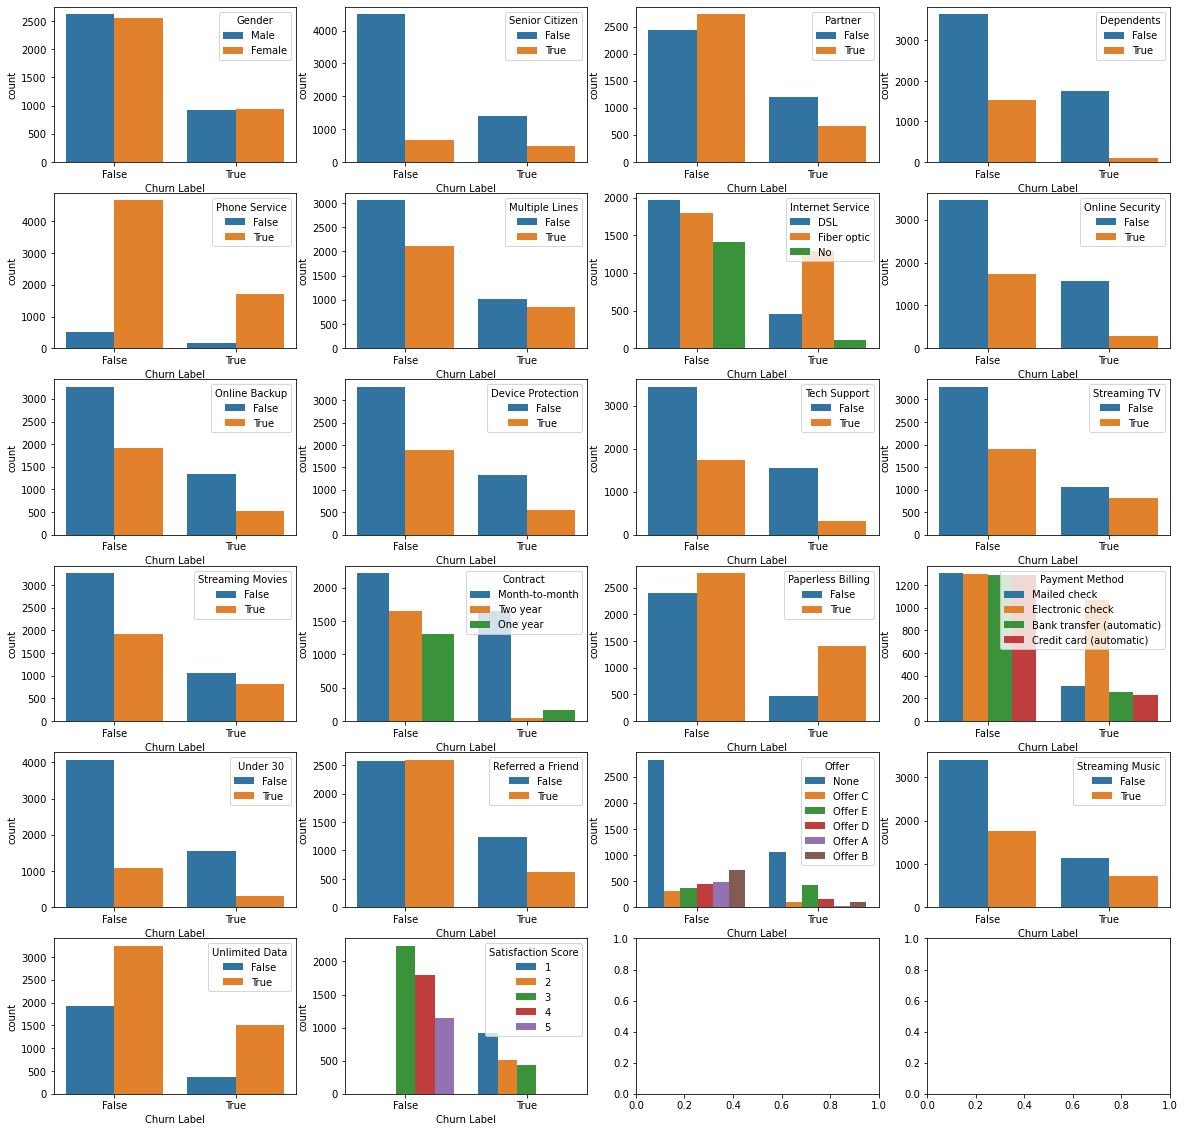

In [21]:
fig, axes = plt.subplots(6, 4, figsize=(20,20), sharey=False)

i, j = 0, 0
for col in telco[['Gender',
                  'Senior Citizen',
                  'Partner',
                  'Dependents',
                  'Phone Service',
                  'Multiple Lines',
                  'Internet Service',
                  'Online Security',
                  'Online Backup',
                  'Device Protection',
                  'Tech Support',
                  'Streaming TV',
                  'Streaming Movies',
                  'Contract',
                  'Paperless Billing',
                  'Payment Method',
                  'Under 30',
                  'Referred a Friend',
                  'Offer',
                  'Streaming Music',
                  'Unlimited Data',
                  'Satisfaction Score',
                ]].columns:

    sns.countplot(ax=axes[i,j], data=telco, x='Churn Label', hue=col)

    if j == 3:
        j = 0
        i += 1
    else:
        j += 1


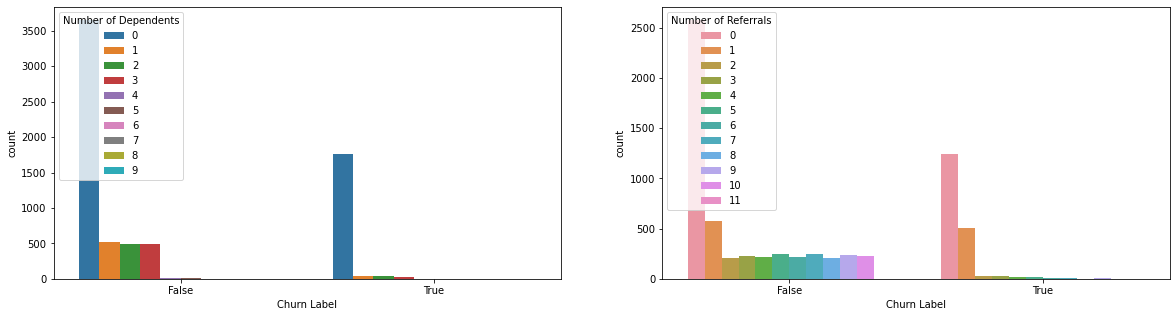

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(20,5), sharey=False)

i = 0
for col in telco[['Number of Dependents',
                  'Number of Referrals',
                 ]].columns:
    

    sns.countplot(ax=axes[i], data=telco, x='Churn Label', hue=col)
    i += 1

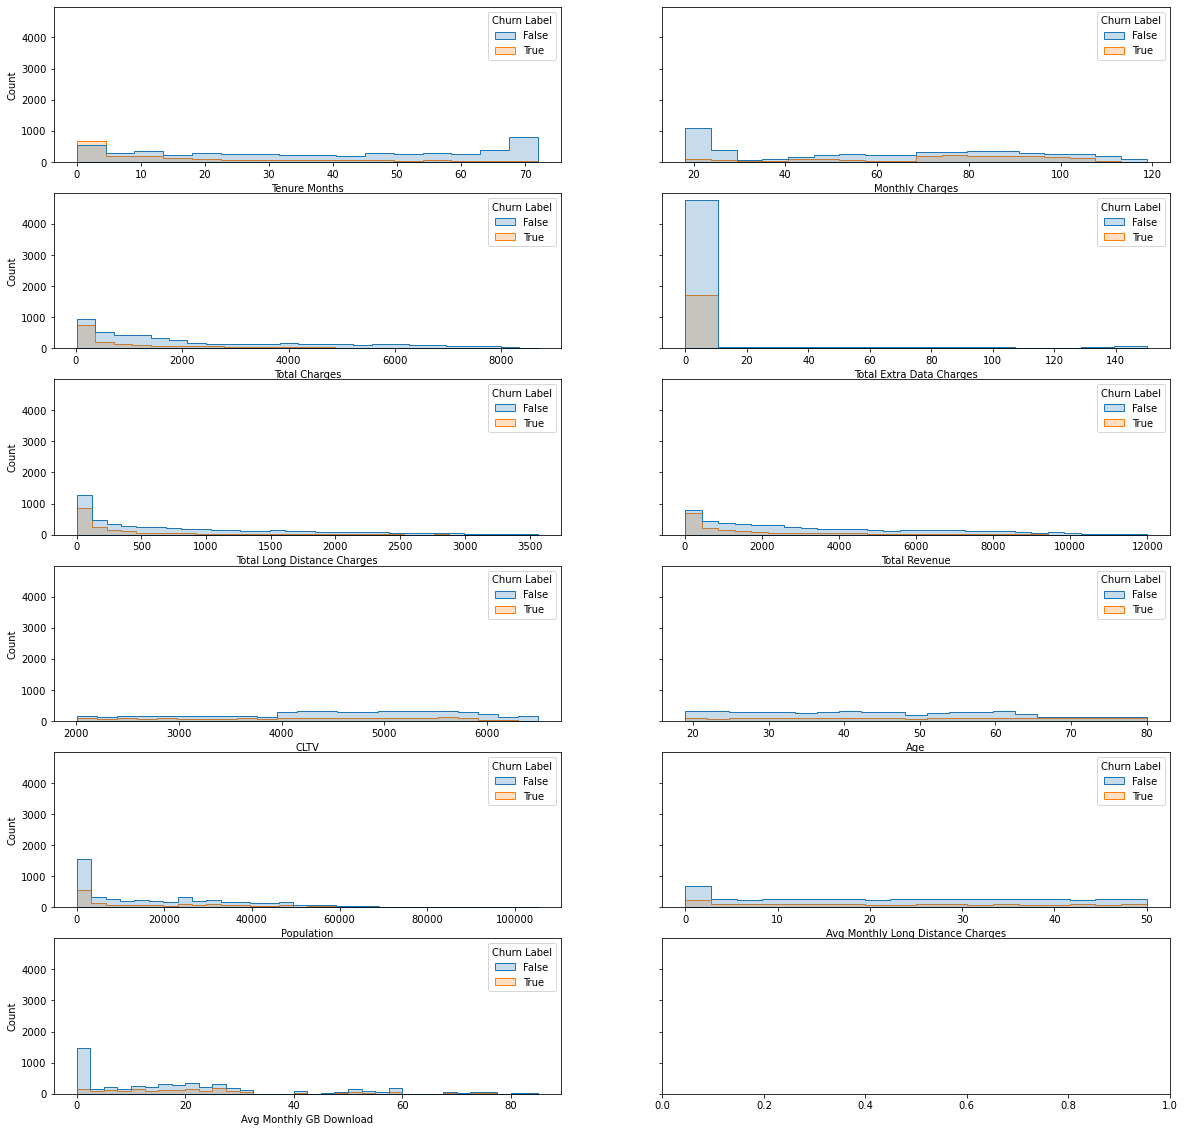

In [23]:
fig, axes = plt.subplots(6, 2, figsize=(20,20), sharey=True)

i, j = 0, 0
for col in telco[['Tenure Months',
                  'Monthly Charges',
                  'Total Charges',
                  'Total Extra Data Charges',
                  'Total Long Distance Charges',
                  'Total Revenue',
                  'CLTV',
                  'Age',
                  'Population',
                  'Avg Monthly Long Distance Charges',
                  'Avg Monthly GB Download'
                 ]].columns:

    sns.histplot(ax=axes[i][j], data=telco, x=col, hue='Churn Label', element='step')

    if j == 1:
        j = 0
        i += 1
    else:
        j += 1


In [24]:
fig = px.scatter(x=telco['Tenure Months'], y=telco['Total Charges'], 
                 color = telco['Churn Label'], template = 'presentation', 
                 opacity = 0.2, facet_col = telco['Contract'], 
                 title = 'Customer Churn by Tenure, Charges, and Contract Type',
                 labels = {'x' : 'Customer Tenure', 'y' : 'Total Charges $'})
                
fig.show()

In [25]:
# Convert columns to Boolean

telco['Gender'] = telco['Gender'].apply(lambda x: True if x == 'Male' else False)
telco['Payment Method'] = telco['Payment Method'].apply(lambda x: True if x == 'Electronic check' else False)
telco['Offer'] = telco['Offer'].apply(lambda x: False if x == 'None' else True)
telco['Internet Service'] = telco['Internet Service'].apply(lambda x: True if x == 'Fiber optic' else False)


telco.rename(columns={'Gender': 'Male',
                      'Payment Method': 'Electronic Check',
                      'Internet Service': 'Fiber Optic'
                     },
             inplace=True
            )

In [26]:
onehot = pd.get_dummies(telco[['Contract']])

telco = pd.merge(telco, onehot, left_index=True, right_index=True, suffixes=(None, None))

telco.drop(columns=['Contract'], inplace=True)

telco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Male                               7043 non-null   bool   
 1   Senior Citizen                     7043 non-null   bool   
 2   Partner                            7043 non-null   bool   
 3   Dependents                         7043 non-null   bool   
 4   Tenure Months                      7043 non-null   int64  
 5   Phone Service                      7043 non-null   bool   
 6   Multiple Lines                     7043 non-null   bool   
 7   Fiber Optic                        7043 non-null   bool   
 8   Online Security                    7043 non-null   bool   
 9   Online Backup                      7043 non-null   bool   
 10  Device Protection                  7043 non-null   bool   
 11  Tech Support                       7043 non-null   bool 

In [27]:
churn_column = telco.pop('Churn Label')
telco.insert(0, 'Churn', churn_column)

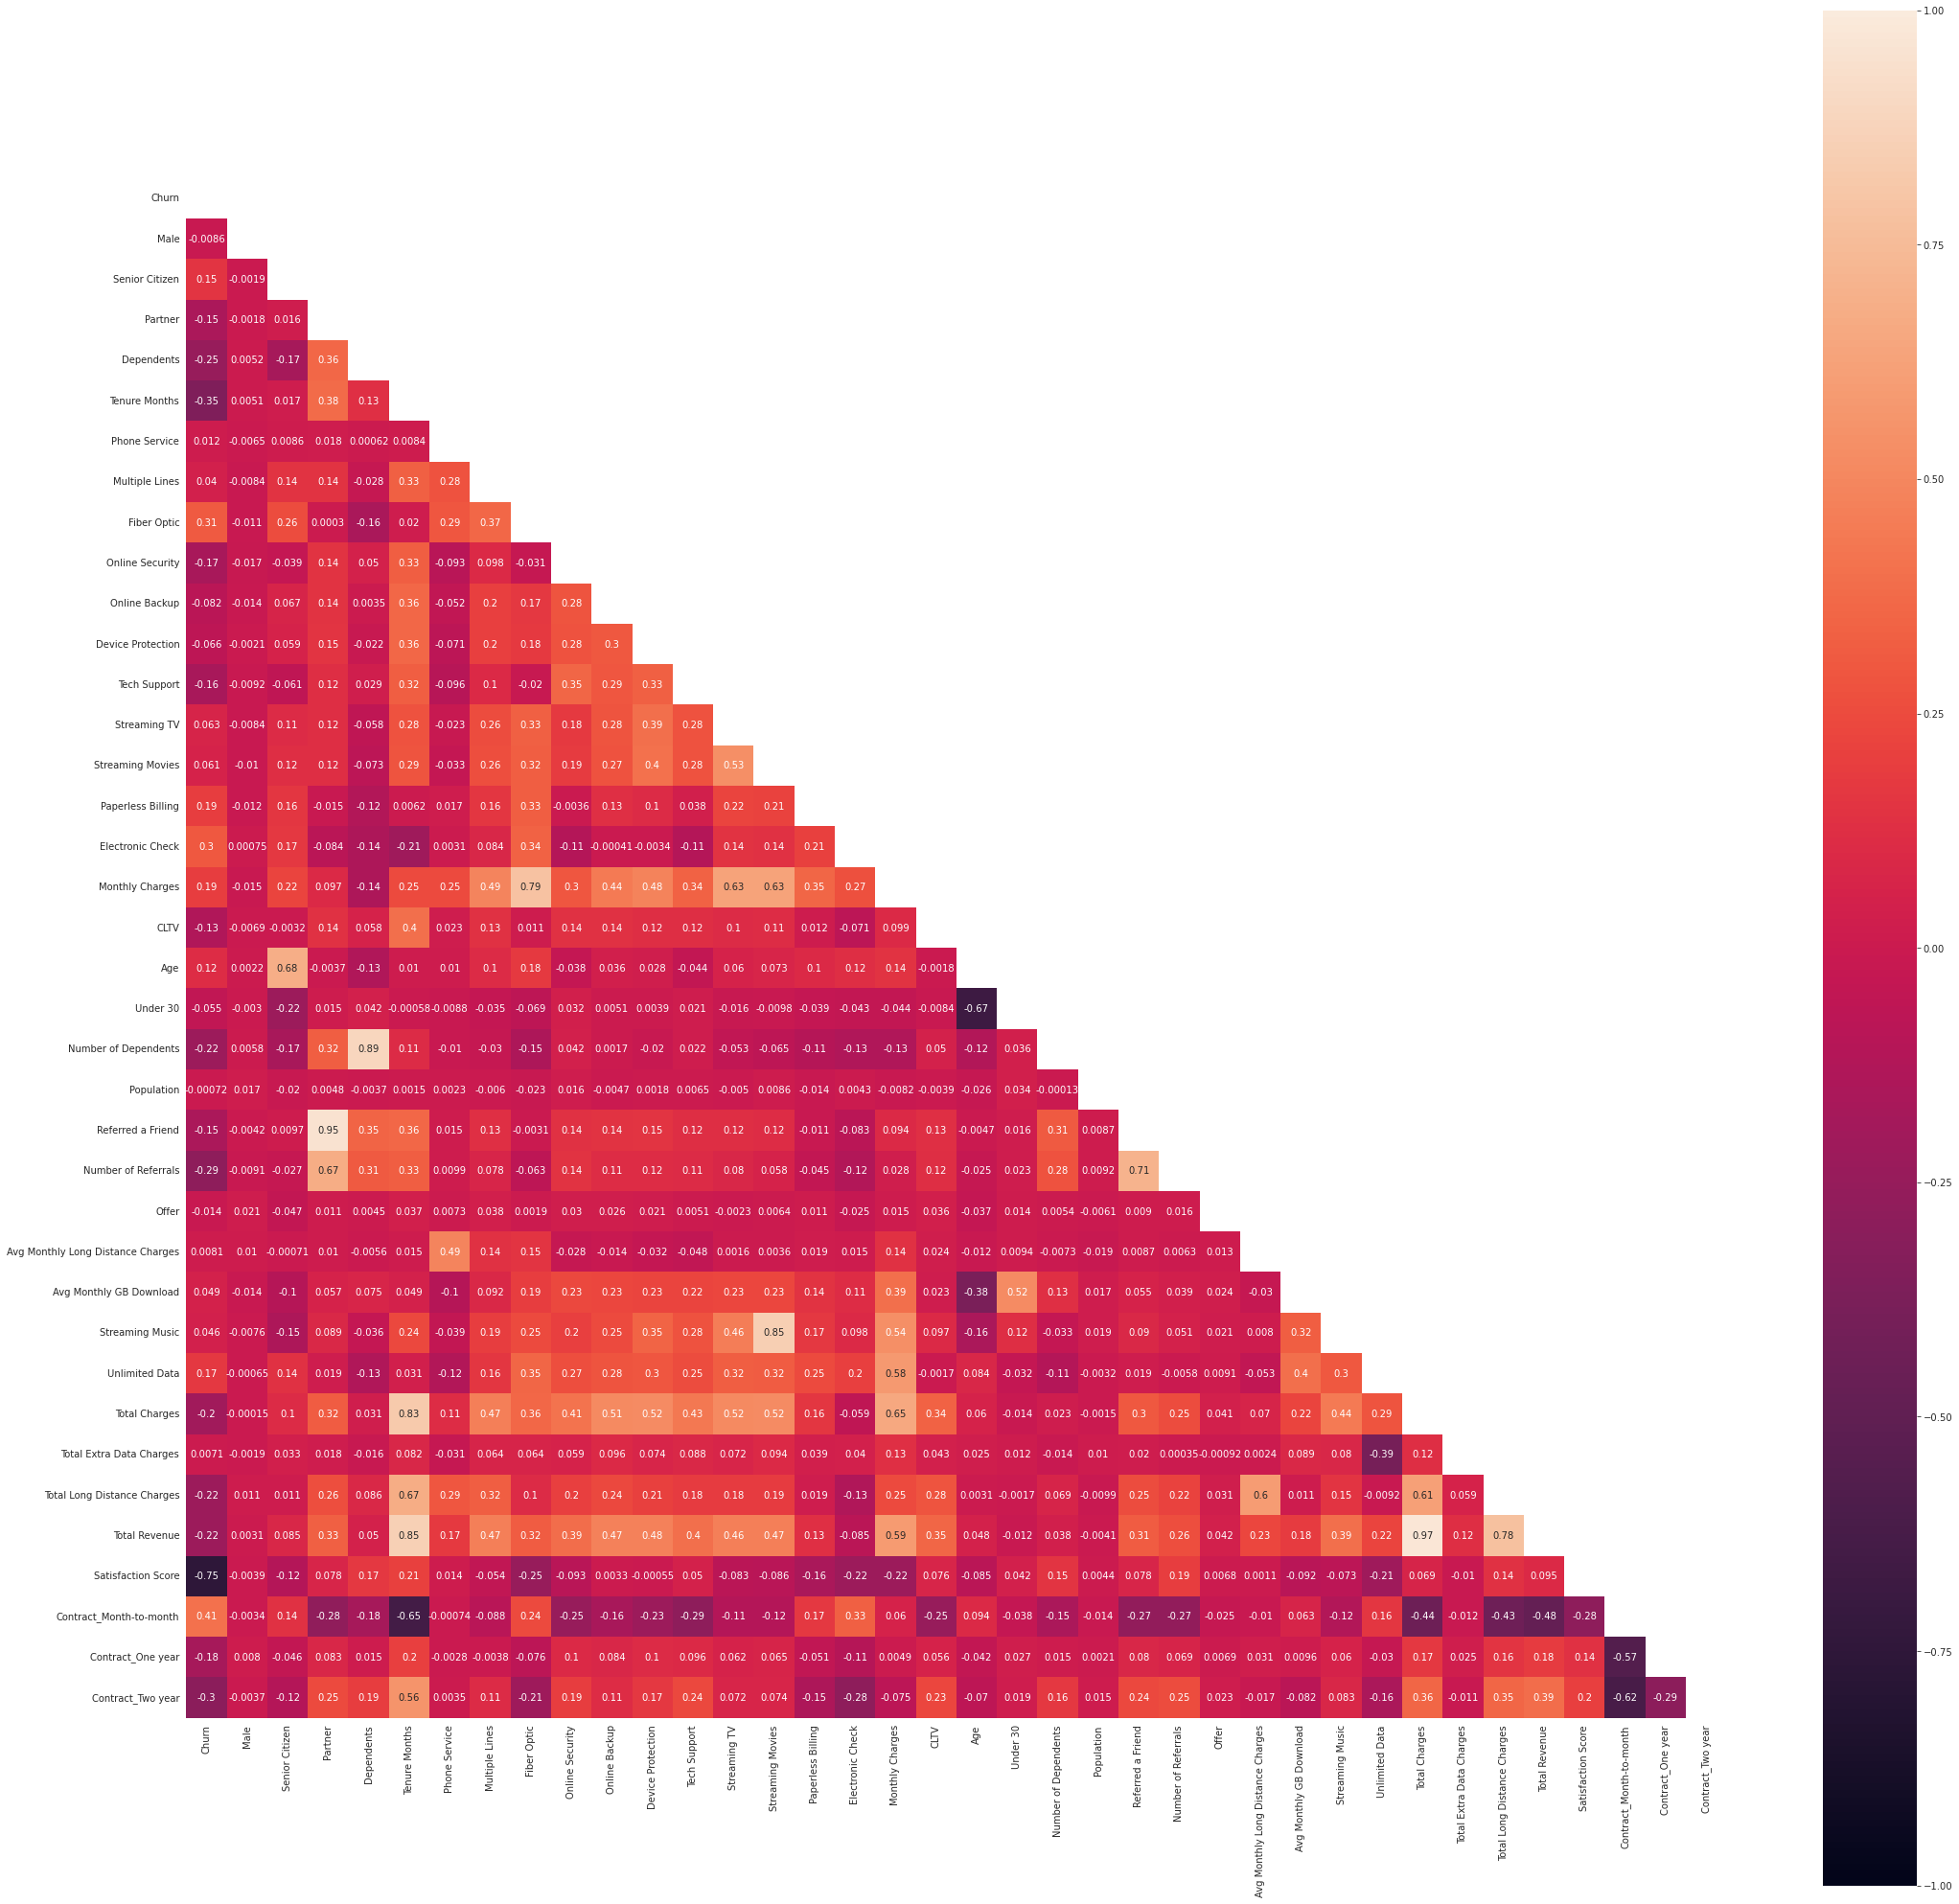

In [28]:
corr = np.array(telco.corr())
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True


with sns.axes_style('white'):
    plt.figure(figsize=(36,36))
    sns.heatmap(corr,
                mask=mask,
                annot=True,
                square=True,
                xticklabels=telco.corr().columns,
                yticklabels=telco.corr().columns,
                vmin=-1,
                vmax=1)
    

In [29]:
# Example of OneHotEncoder
# Duplicative with pd.get_dummies used above

# encoder = OneHotEncoder(handle_unknown='ignore', drop='if_binary')

# encoder.fit_transform(telco[['Contract']])

# encoder.get_feature_names_out()

---
## 3.0 Setup Models

In [36]:
X.columns

Index(['Male', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months',
       'Phone Service', 'Multiple Lines', 'Fiber Optic', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Paperless Billing', 'Electronic Check',
       'Monthly Charges', 'CLTV', 'Age', 'Under 30', 'Number of Dependents',
       'Population', 'Referred a Friend', 'Number of Referrals', 'Offer',
       'Avg Monthly Long Distance Charges', 'Avg Monthly GB Download',
       'Streaming Music', 'Unlimited Data', 'Total Charges',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Satisfaction Score', 'Contract_Month-to-month',
       'Contract_One year', 'Contract_Two year'],
      dtype='object')

In [60]:
lr = LogisticRegression()
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
gb = GradientBoostingClassifier()

models = [lr, rf, dt, gb]
# models = [lr]

# y = telco.pop('Churn')
# X = telco

Confusion matrix of logistic regression classifier


/Users/dmiller/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



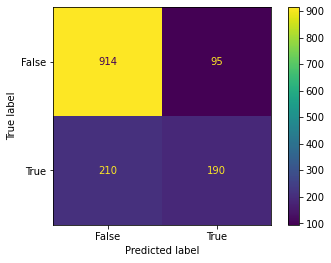

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
accuracy = lr.score(X_test, y_test)


cm = confusion_matrix(y_test, y_pred)

print("\033[1m" + "Confusion matrix of logistic regression classifier" + "\033[0m")    
# Plot confusion matrix using sklearn function
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()


Confusion matrix of random forest classifier


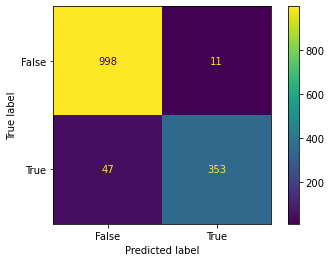

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = rf.score(X_test, y_test)


cm = confusion_matrix(y_test, y_pred)

print("\033[1m" + "Confusion matrix of random forest classifier" + "\033[0m")    
# Plot confusion matrix using sklearn function
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [84]:
def compare_models(X, y, models):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
    feature_names = X.columns
    
    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = model.score(X_test, y_test)


        cm = confusion_matrix(y_test, y_pred)

        # Confusion matrix plot
        print("\033[1m" + "Confusion matrix of {} classifier".format(model) + "\033[0m")    
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
        plt.show()
        


Confusion matrix of LogisticRegression() classifier


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


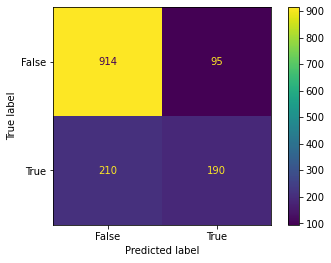

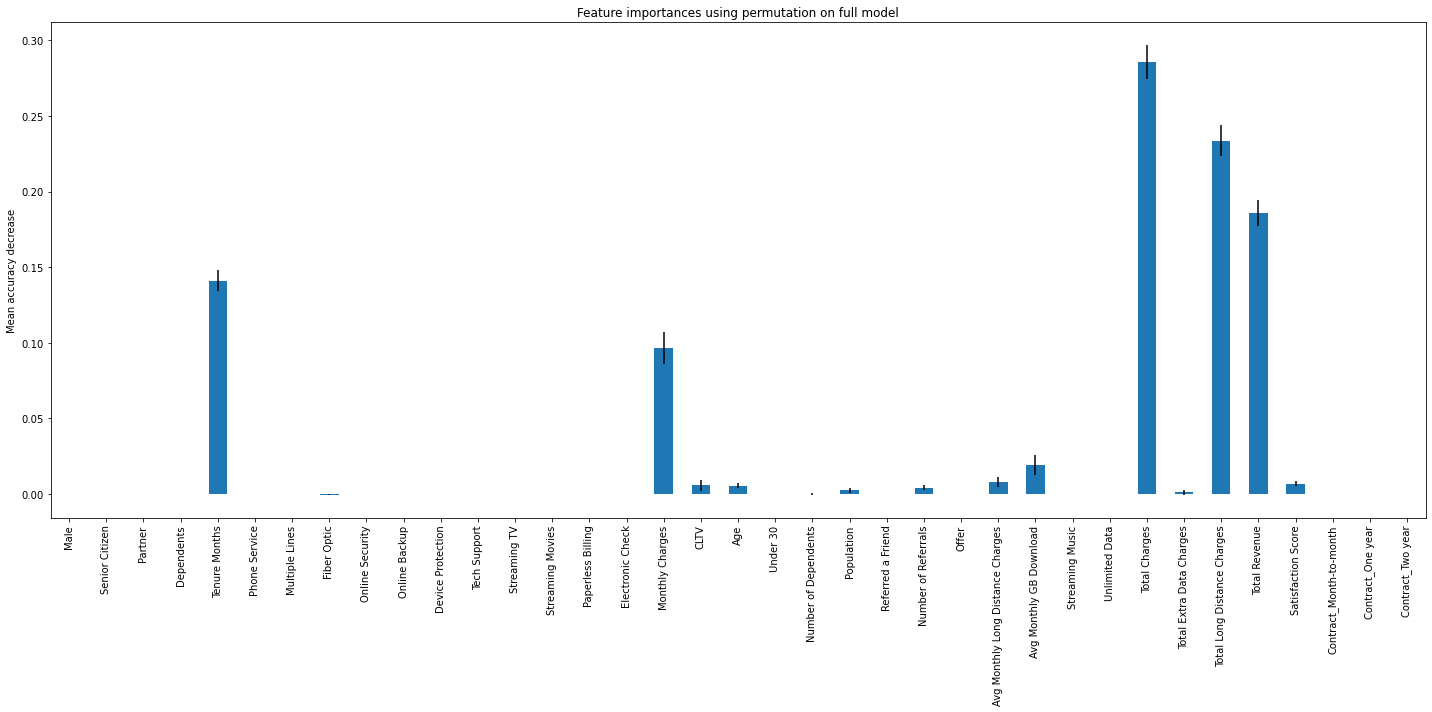

Confusion matrix of RandomForestClassifier() classifier


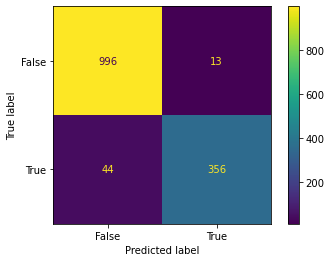

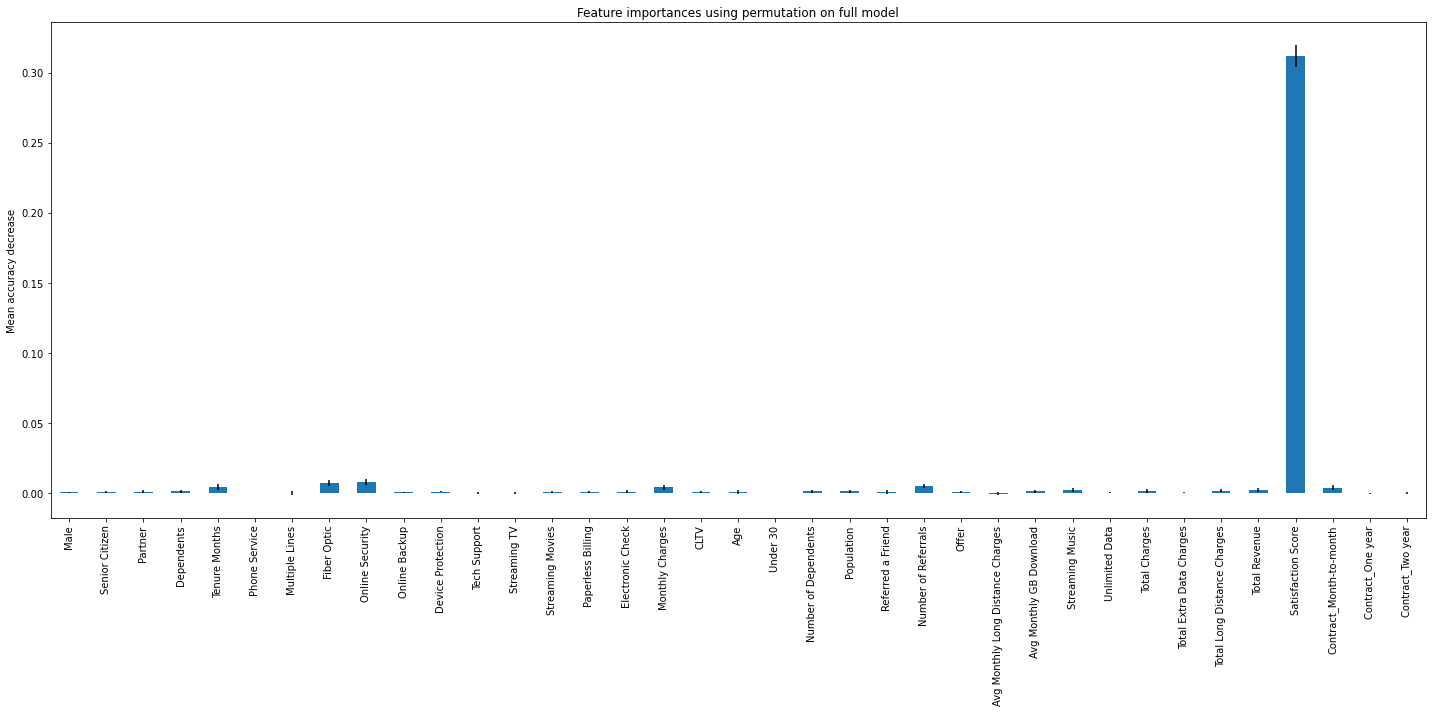

Confusion matrix of DecisionTreeClassifier() classifier


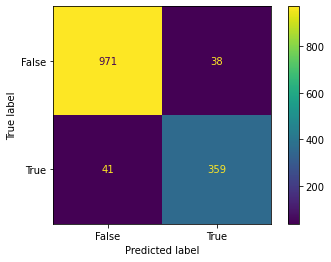

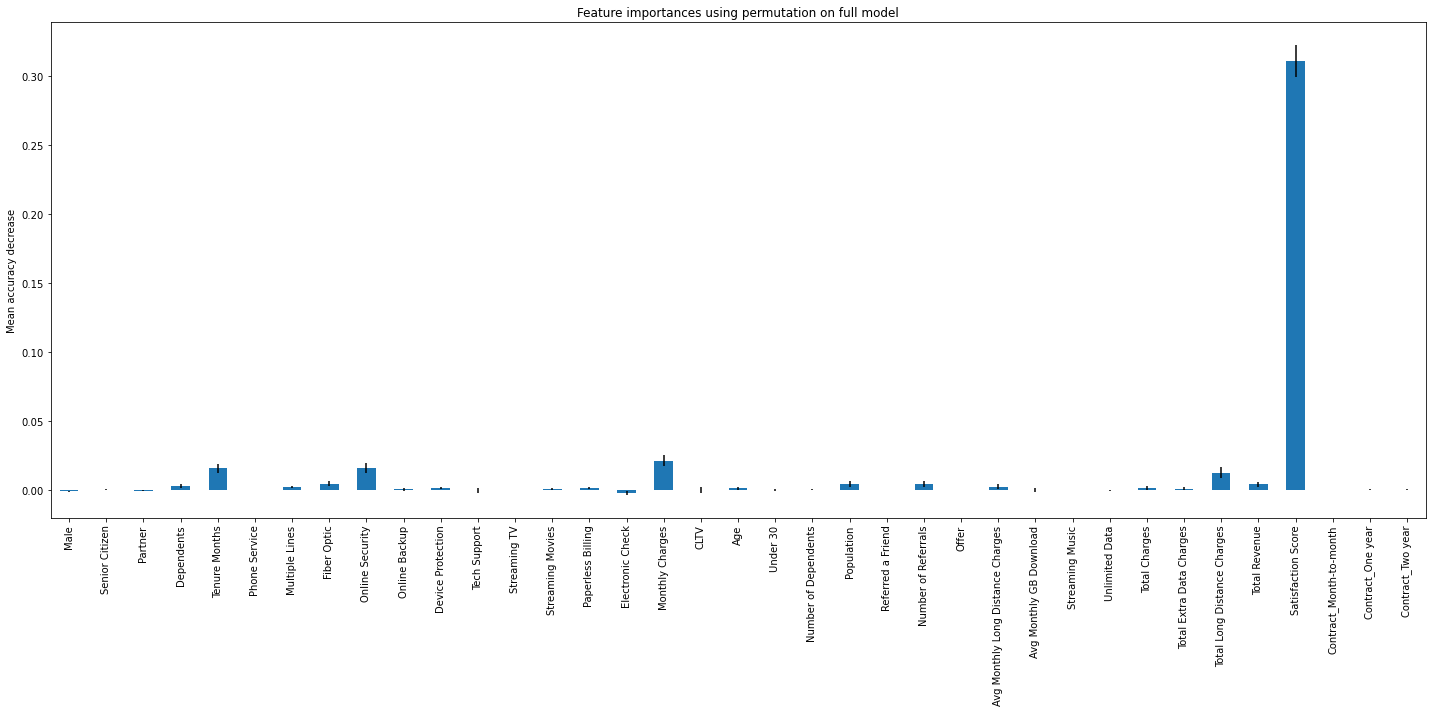

Confusion matrix of GradientBoostingClassifier() classifier


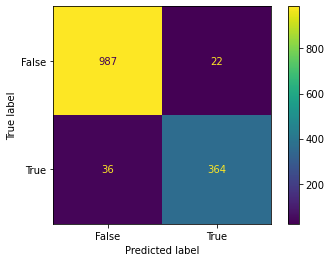

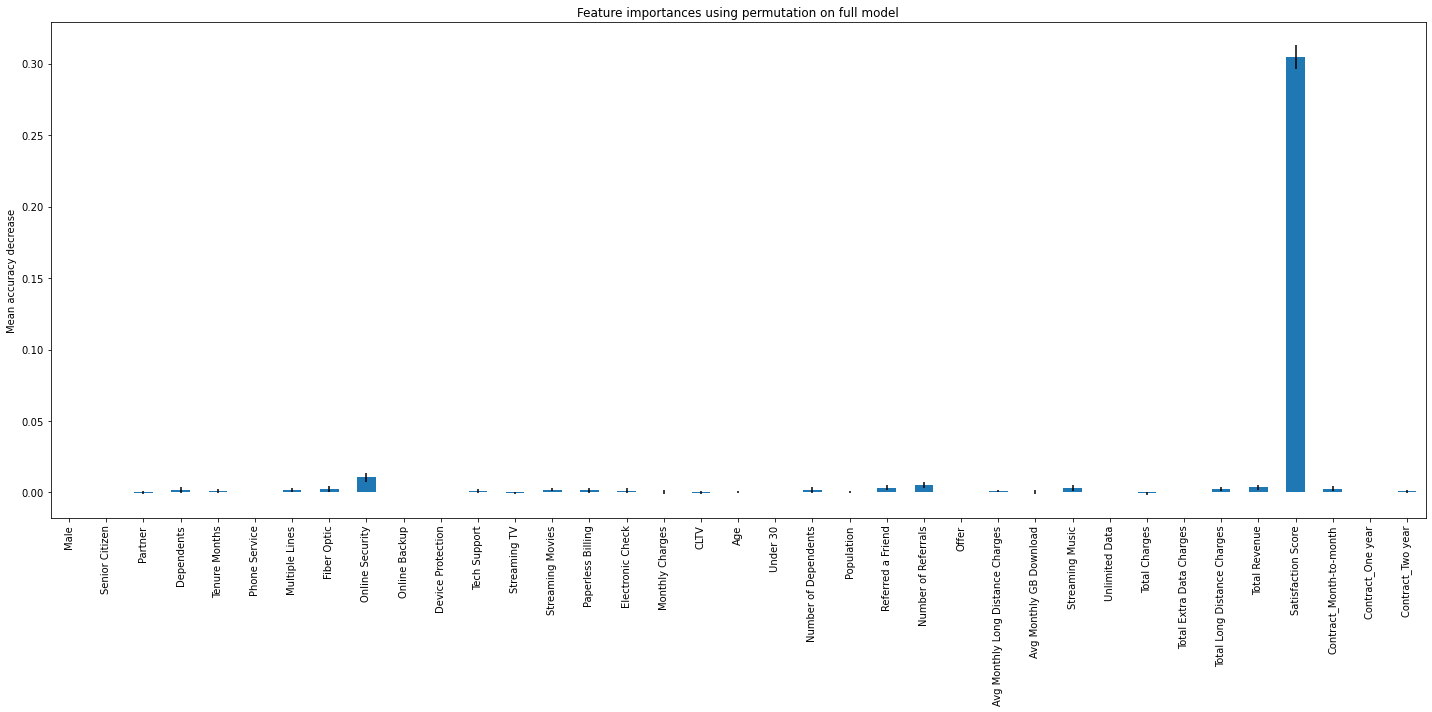

In [85]:
compare_models(X, y, models)

In [42]:
feature_names = X.columns

Text(0, 0.5, 'Mean decrease in impurity')

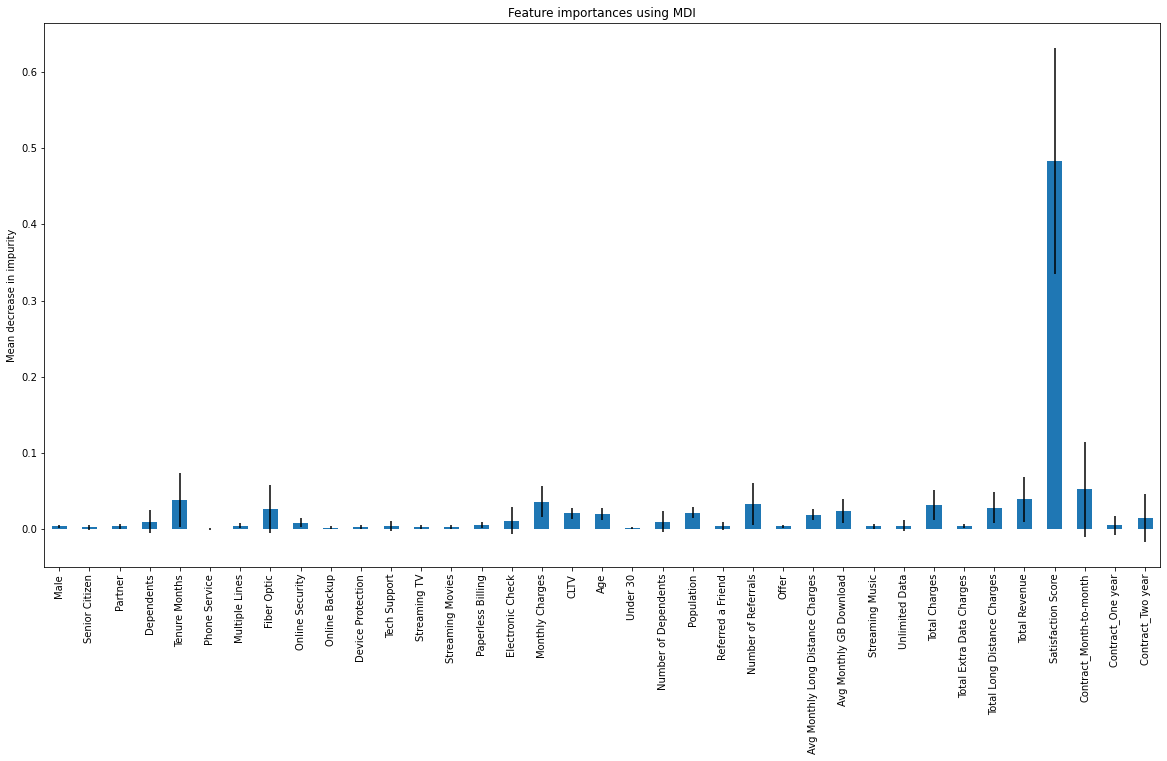

In [43]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(20,10))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout()

In [45]:
from sklearn.inspection import permutation_importance

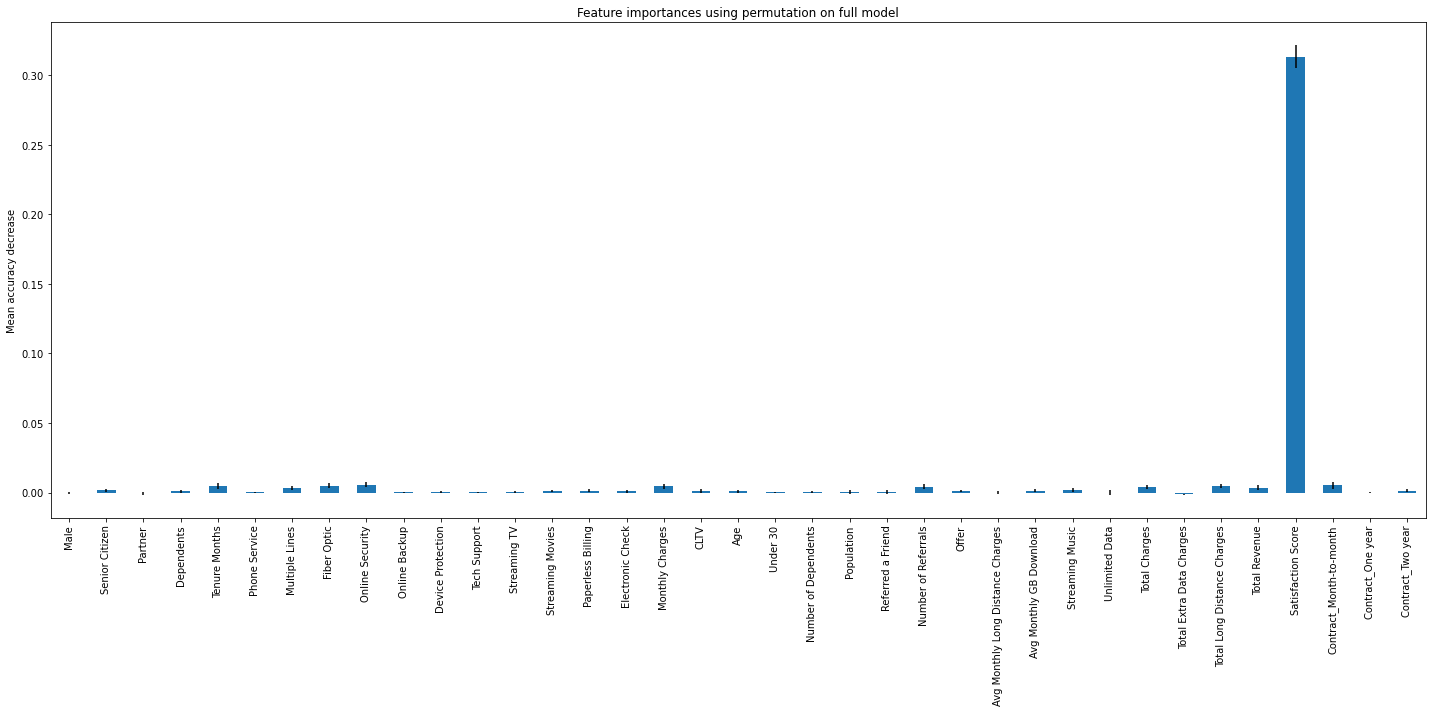

In [47]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots(figsize=(20,10))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [51]:
import shap

In [52]:
shap.initjs()

In [53]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X)

In [63]:
# Force plot - needs to be debugged
# i = 0
# shap.force_plot(explainer.expected_value[i], shap_values[i], features=X.iloc[i], feature_names=feature_names)

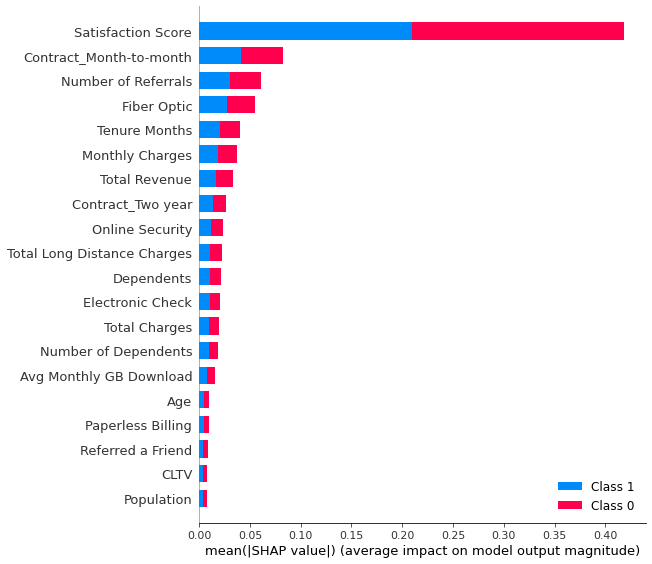

In [69]:
# Research why my problem is multi-class label and therefore only bar plot available
shap.summary_plot(shap_values, features=X, feature_names=feature_names)

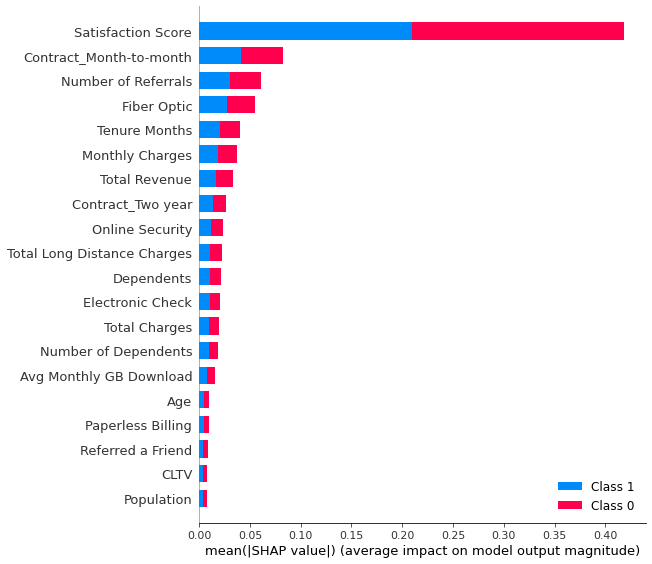

In [65]:
shap.summary_plot(shap_values, features=X, feature_names=feature_names, plot_type='bar')

#### 3.1a Example of OneHotEncoding + Scaling + Re-combining

In [ ]:
# Import libraries and download example data
from sklearn.preprocessing import StandardScaler, OneHotEncoder

dataset = pd.read_csv("https://stats.idre.ucla.edu/stat/data/binary.csv")
print(dataset.head(5))

# Define which columns should be encoded vs scaled
columns_to_encode = ['rank']
columns_to_scale  = ['gre', 'gpa']

# Instantiate encoder/scaler
scaler = StandardScaler()
ohe    = OneHotEncoder(sparse=False)

# Scale and Encode Separate Columns
scaled_columns  = scaler.fit_transform(dataset[columns_to_scale]) 
encoded_columns =    ohe.fit_transform(dataset[columns_to_encode])

# Concatenate (Column-Bind) Processed Columns Back Together
processed_data = np.concatenate([scaled_columns, encoded_columns], axis=1)

cols1 = np.array(scaler.get_feature_names_out())
cols2 = np.array(ohe.get_feature_names_out())
cols = np.concatenate((cols1, cols2))


df = pd.DataFrame(processed_data,
                  columns=cols
                 
                 )
df.head(5)